### Objetivo deste notebook

#### Identificar a causa raiz da queda na avaliação média dos pedidos. 
i) Há realmente uma queda? <p>
ii) Em que momento a queda acontece? 

In [143]:
# Importar as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from src.paths import DATA_INPUTS_OUTPUTS, IMAGES

plt.style.use('bmh')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
pd.set_option('display.max_columns', 366)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
%config Completer.use_jedi = False

In [145]:
# Carregar os dados
Order_rating_DB = pd.read_csv(DATA_INPUTS_OUTPUTS / 'OrderRatingDB.csv')
Bad_Rating_reasons = pd.read_excel(DATA_INPUTS_OUTPUTS / 'Data Analyst _ Zé Delivery Data Base.xlsx', sheet_name='Bad Rating reasons')
Rating_email_data = pd.read_excel(DATA_INPUTS_OUTPUTS / 'Data Analyst _ Zé Delivery Data Base.xlsx', sheet_name='Rating e-mail data')

In [146]:
Order_rating_DB['Date&Time'] = pd.to_datetime(Order_rating_DB['Date&Time'])

In [147]:
# Adicionar colunas
Order_rating_DB['date'] = pd.to_datetime(Order_rating_DB['Date&Time'].dt.date)
Order_rating_DB['hour'] = Order_rating_DB['Date&Time'].dt.hour
Order_rating_DB['day'] = Order_rating_DB['Date&Time'].dt.day
Order_rating_DB['month'] = Order_rating_DB['Date&Time'].dt.month
Order_rating_DB['month-day'] = Order_rating_DB['Date&Time'].dt.strftime('%m%d')

bins = [0, 6, 12, 18, 25]
labels = ['0h-6h','6h-12h','12h-18h','18h-24h']
Order_rating_DB['PeriodOfDay'] = pd.cut(Order_rating_DB['hour'], bins=bins, labels=labels, right=False)

In [148]:
# Tamanho do dataset
Order_rating_DB.shape

(11257, 21)

In [149]:
# Tipo dos dados
Order_rating_DB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11257 entries, 0 to 11256
Data columns (total 21 columns):
OrderID               11257 non-null int64
OrderNumber           11257 non-null int64
Week                  11257 non-null int64
Date&Time             11257 non-null datetime64[ns]
Comment               127 non-null object
User                  11257 non-null object
MerchandiseRevenue    11257 non-null float64
PaymentMethod         5988 non-null object
POCID                 11257 non-null int64
Rating                5134 non-null float64
Reasons               0 non-null float64
ShippingType          11257 non-null object
State                 11237 non-null object
CorrectWeek           11257 non-null int64
CorrectState          11237 non-null object
date                  11257 non-null datetime64[ns]
hour                  11257 non-null int64
day                   11257 non-null int64
month                 11257 non-null int64
month-day             11257 non-null object
PeriodOf

#### Existe uma queda?

In [150]:
# Conforme orientações, -1, 0 ou em branco não são considerados na classificação média de pedidos
filtro = [-1,0,np.nan]
classificacao = Order_rating_DB[~Order_rating_DB['Rating'].isin(filtro)]
classificacao.sample(5)

,OrderID,OrderNumber,Week,Date&Time,Comment,User,MerchandiseRevenue,PaymentMethod,POCID,Rating,Reasons,ShippingType,State,CorrectWeek,CorrectState,date,hour,day,month,month-day,PeriodOfDay
1164,201073,23750,11,2017-03-12 10:50:11,NaN,user5019gmail.com,63.496,NaN,23,5.0,NaN,receber,SP,10,SP,2017-03-12,10,12,3,0312,6h-12h
1895,207158,29835,16,2017-04-13 17:21:29,NaN,user1223gmail.com,28.744,NaN,21,5.0,NaN,receber,SP,15,SP,2017-04-13,17,13,4,0413,12h-18h
4781,230919,53597,26,2017-06-23 08:48:38,NaN,user2771gmail.com,91.968,NaN,21,5.0,NaN,receber,SP,25,SP,2017-06-23,8,23,6,0623,6h-12h
10258,248200,2286623,42,2017-10-13 10:15:34,NaN,user17554gmail.com,79.776,Débito,61,5.0,NaN,receber,São Paulo,41,SP,2017-10-13,10,13,10,1013,6h-12h
9457,241690,81611702,40,2017-09-30 17:17:02,NaN,user14274gmail.com,29.880,Débito,21,5.0,NaN,receber,São Paulo,39,SP,2017-09-30,17,30,9,0930,12h-18h


In [151]:
# Quanto representa, do total, os registros que têm algum avaliação 
round(
    classificacao['OrderID'].count() / Order_rating_DB['OrderID']
    .count(),
    2
) * 100

42.0

Os registros com alguma avaliação representam cerca de 40% do total. Adiante, veremos como é essa participação ao longo dos meses.

#### Avaliação média por dia

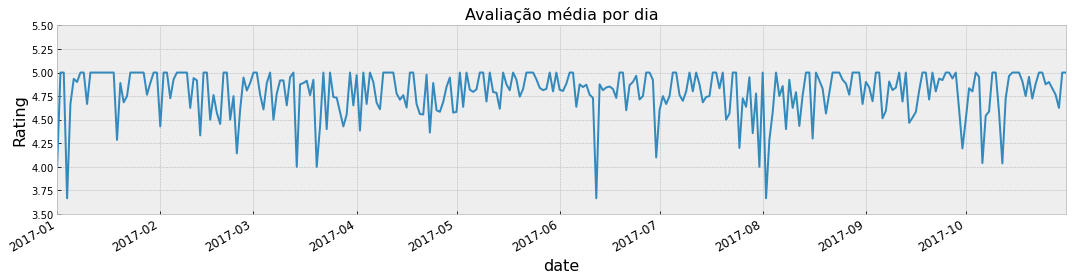

In [152]:
(classificacao.groupby('date')['Rating'].mean()
 .plot(figsize=(15,4),
       ylim=(3.5,5.5), 
       title='Avaliação média por dia'), 
 plt.ylabel('Rating')
),plt.tight_layout(), plt.savefig(IMAGES / 'av_dia.png');

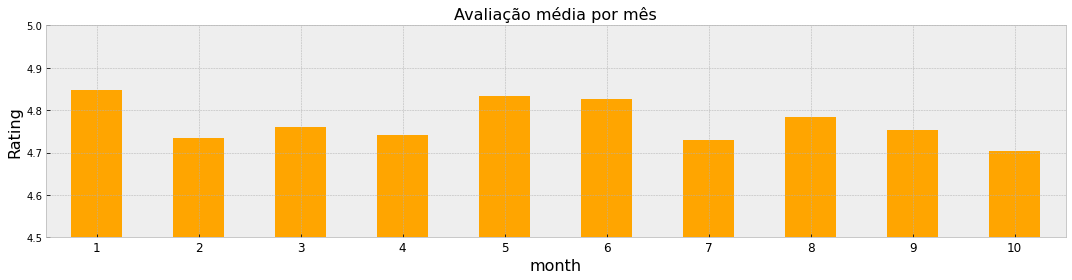

In [222]:
(classificacao.groupby('month')['Rating'].mean()
 .plot.bar(figsize=(15,4),
           ylim=(4.5,5), 
           title='Avaliação média por mês', 
        color='orange'),
 plt.ylabel('Rating')
), plt.xticks(rotation=0), 
plt.tight_layout(), plt.savefig(IMAGES / 'av_mes.png');

A média da avaliação diária varia bastante ao longo do período. Percebe-se, realmente, que no final de julho há uma queda um pouco mais agressiva em relação a períodos anteriores. Contudo, em fevereiro e março também observa-se vários picos de queda (não tão agressivos), assim como em meados de junho percebe-se uma pico de queda agressivo. 

**Inicialmente, os dados não parecem demonstrar uma queda relevante em julho.**

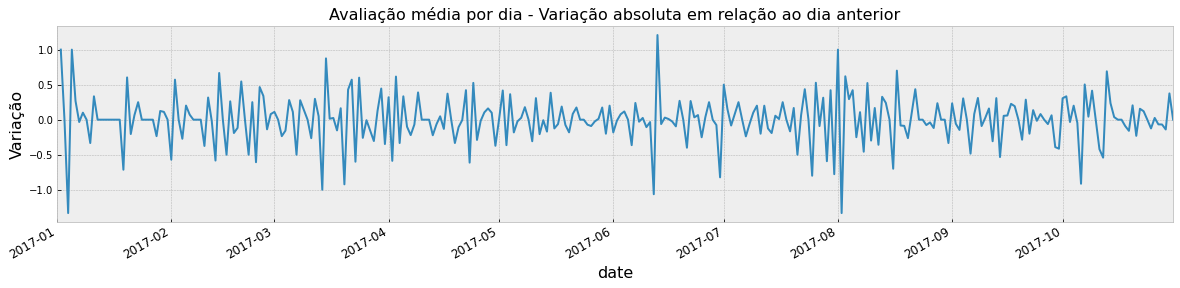

In [154]:
(classificacao.groupby('date')['Rating'].mean().diff()
 .plot(figsize=(20,4),
       title='Avaliação média por dia - Variação absoluta em relação ao dia anterior'), 
 plt.ylabel('Variação')
);

Vemos uma certa agressividade maior na variação média diária no final de julho, mas há também similares oscilações em outros períodos.

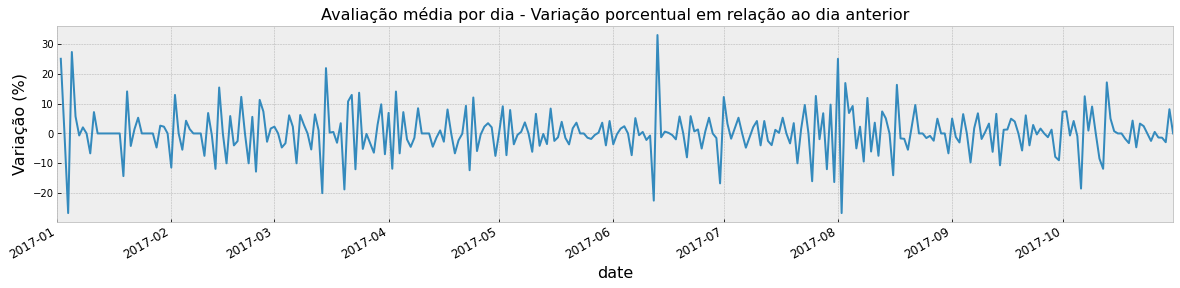

In [155]:
(classificacao.groupby('date')['Rating'].mean().pct_change().multiply(100)
 .plot(figsize=(20,4),
       title='Avaliação média por dia - Variação porcentual em relação ao dia anterior'), 
 plt.ylabel('Variação (%)')
);

Em termos percentuais, a oscilação diária em julho se aproximou de -18%, porém, esse comportamento também pode ser visto em outros períodos. O que mais uma vez demonstra que julho não foi mês atípico.

In [156]:
# Vamos olhar a dispersão dos dados ao longo dos dias
classificacao.groupby('date')['Rating'].describe().T

date,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-07 00:00:00,2017-01-08 00:00:00,2017-01-09 00:00:00,2017-01-10 00:00:00,2017-01-11 00:00:00,2017-01-12 00:00:00,2017-01-13 00:00:00,2017-01-14 00:00:00,2017-01-15 00:00:00,2017-01-16 00:00:00,2017-01-17 00:00:00,2017-01-18 00:00:00,2017-01-19 00:00:00,2017-01-20 00:00:00,2017-01-21 00:00:00,2017-01-22 00:00:00,2017-01-23 00:00:00,2017-01-24 00:00:00,2017-01-25 00:00:00,2017-01-26 00:00:00,2017-01-27 00:00:00,2017-01-28 00:00:00,2017-01-29 00:00:00,2017-01-30 00:00:00,2017-01-31 00:00:00,2017-02-01 00:00:00,2017-02-02 00:00:00,2017-02-03 00:00:00,2017-02-04 00:00:00,2017-02-05 00:00:00,2017-02-06 00:00:00,2017-02-07 00:00:00,2017-02-08 00:00:00,2017-02-09 00:00:00,2017-02-10 00:00:00,2017-02-11 00:00:00,2017-02-12 00:00:00,2017-02-13 00:00:00,2017-02-14 00:00:00,2017-02-15 00:00:00,2017-02-16 00:00:00,2017-02-17 00:00:00,2017-02-18 00:00:00,2017-02-19 00:00:00,2017-02-20 00:00:00,2017-02-21 00:00:00,2017-02-22 00:00:00,2017-02-23 00:00:00,2017-02-24 00:00:00,2017-02-25 00:00:00,2017-02-26 00:00:00,2017-02-27 00:00:00,2017-02-28 00:00:00,2017-03-01 00:00:00,2017-03-02 00:00:00,2017-03-03 00:00:00,2017-03-04 00:00:00,2017-03-05 00:00:00,2017-03-06 00:00:00,2017-03-07 00:00:00,2017-03-08 00:00:00,2017-03-09 00:00:00,2017-03-10 00:00:00,2017-03-11 00:00:00,2017-03-12 00:00:00,2017-03-13 00:00:00,2017-03-14 00:00:00,2017-03-15 00:00:00,2017-03-16 00:00:00,2017-03-17 00:00:00,2017-03-18 00:00:00,2017-03-19 00:00:00,2017-03-20 00:00:00,2017-03-21 00:00:00,2017-03-22 00:00:00,2017-03-23 00:00:00,2017-03-24 00:00:00,2017-03-25 00:00:00,2017-03-26 00:00:00,2017-03-28 00:00:00,2017-03-29 00:00:00,2017-03-30 00:00:00,2017-03-31 00:00:00,2017-04-01 00:00:00,2017-04-02 00:00:00,2017-04-03 00:00:00,2017-04-04 00:00:00,2017-04-05 00:00:00,2017-04-06 00:00:00,2017-04-07 00:00:00,2017-04-08 00:00:00,2017-04-09 00:00:00,2017-04-10 00:00:00,2017-04-11 00:00:00,2017-04-12 00:00:00,2017-04-13 00:00:00,2017-04-14 00:00:00,2017-04-15 00:00:00,2017-04-16 00:00:00,2017-04-17 00:00:00,2017-04-18 00:00:00,2017-04-19 00:00:00,2017-04-20 00:00:00,2017-04-21 00:00:00,2017-04-22 00:00:00,2017-04-23 00:00:00,2017-04-24 00:00:00,2017-04-25 00:00:00,2017-04-26 00:00:00,2017-04-27 00:00:00,2017-04-28 00:00:00,2017-04-29 00:00:00,2017-04-30 00:00:00,2017-05-01 00:00:00,2017-05-02 00:00:00,2017-05-03 00:00:00,2017-05-04 00:00:00,2017-05-05 00:00:00,2017-05-06 00:00:00,2017-05-07 00:00:00,2017-05-08 00:00:00,2017-05-09 00:00:00,2017-05-10 00:00:00,2017-05-11 00:00:00,2017-05-12 00:00:00,2017-05-13 00:00:00,2017-05-14 00:00:00,2017-05-15 00:00:00,2017-05-16 00:00:00,2017-05-17 00:00:00,2017-05-18 00:00:00,2017-05-19 00:00:00,2017-05-20 00:00:00,2017-05-21 00:00:00,2017-05-22 00:00:00,2017-05-23 00:00:00,2017-05-24 00:00:00,2017-05-25 00:00:00,2017-05-26 00:00:00,2017-05-27 00:00:00,2017-05-28 00:00:00,2017-05-29 00:00:00,2017-05-30 00:00:00,2017-05-31 00:00:00,2017-06-01 00:00:00,2017-06-02 00:00:00,2017-06-03 00:00:00,2017-06-04 00:00:00,2017-06-05 00:00:00,2017-06-06 00:00:00,2017-06-07 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,2017-06-10 00:00:00,2017-06-11 00:00:00,2017-06-12 00:00:00,2017-06-13 00:00:00,2017-06-14 00:00:00,2017-06-15 00:00:00,2017-06-16 00:00:00,2017-06-17 00:00:00,2017-06-18 00:00:00,2017-06-19 00:00:00,2017-06-20 00:00:00,2017-06-21 00:00:00,2017-06-22 00:00:00,2017-06-23 00:00:00,2017-06-24 00:00:00,2017-06-25 00:00:00,2017-06-26 00:00:00,2017-06-27 00:00:00,2017-06-28 00:00:00,2017-06-29 00:00:00,2017-06-30 00:00:00,2017-07-01 00:00:00,2017-07-02 00:00:00,2017-07-03 00:00:00,2017-07-04 00:00:00,2017-07-05 00:00:00,2017-07-06 00:00:00,2017-07-07 00:00:00,2017-07-08 00:00:00,2017-07-09 00:00:00,2017-07-10 00:00:00,2017-07-11 00:00:00,2017-07-12 00:00:00,2017-07-13 00:00:00,2017-07-14 00:00:00,2017-07-15 00:00:00,2017-07-16 00:00:00,2017-07-17 00:00:00,2017-07-18 00:00:00,2017-07-19 00:00:00,2017-07-20 00:0

In [157]:
# Vamos olhar a dispersão dos dados ao longo dos meses
classificacao.groupby('month')['Rating'].describe().T

month,1,2,3,4,5,6,7,8,9,10
count,216.000000,331.000000,384.000000,655.000000,613.000000,585.000000,372.000000,465.000000,655.000000,474.000000
mean,4.847222,4.734139,4.760417,4.741985,4.833605,4.825641,4.728495,4.784946,4.752672,4.702532
std,0.632302,0.853876,0.801367,0.836290,0.675224,0.714593,0.833235,0.774728,0.851274,0.913901
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Interessante notar que a quantidade diária de envio de avaliaçãoes oscila bastante. Além disso, em vários dias, o número de envios é bem baixo, o que pode acabar prejudicando  a qualidade da média. <p>
Outro ponto interessante: em praticamente todos os dias temos pelo menos uma avaliação 5.

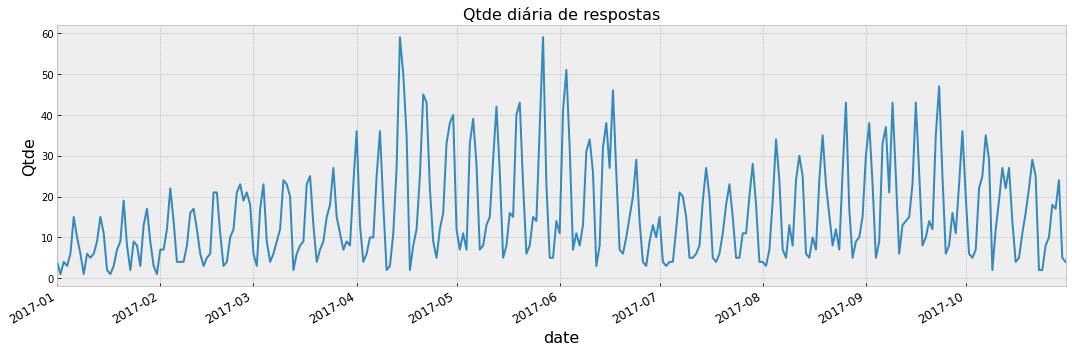

In [158]:
# Vamos ver a quantidade diária de envios de avaliações.
(classificacao.groupby('date')['Rating']
 .count()
 .plot.line(figsize=(15,5),
            title='Qtde diária de respostas'),
 plt.ylabel('Qtde')
), plt.tight_layout(), plt.savefig(IMAGES / 'qtde_res_dia.png');

Conforme havia sido adiantado no case, o mês de julho apresenta menos envio de avaliações que os meses anteriores. Vamos ver como é o comportamento no mês fechado.

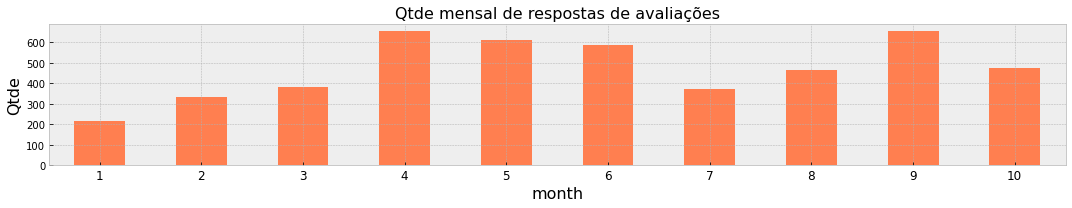

In [220]:
(classificacao.groupby('month')['Rating']
 .count()
 .plot.bar(figsize=(15,3), color='coral',
            title='Qtde mensal de respostas de avaliações'),
 plt.ylabel('Qtde'), plt.xticks(rotation=0)
), plt.tight_layout(), plt.savefig(IMAGES / 'qtde_res_mes.png');

Realmente em julho há uma significativa queda em relação aos 3 meses anteriores.

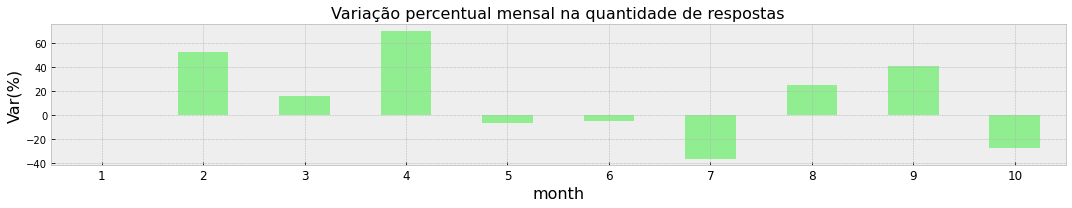

In [221]:
(classificacao.groupby('month')['Rating']
 .count()
 .pct_change()
 .multiply(100)
 .plot.bar(figsize=(15,3), 
           color='lightgreen',
           title='Variação percentual mensal na quantidade de respostas')
),plt.ylabel('Var(%)'), plt.xticks(rotation=0)
plt.tight_layout(), plt.savefig(IMAGES / 'var_qtde_res_mes.png');

A queda no número de envio de avaliações foi em quase 40%. Vamos ver qual a quantidade mensal de envio de avaliações por nota (0-5).

In [161]:
classificacao_por_mes_rating = classificacao.pivot_table(index='Rating',
                                                      columns='month',
                                                      values='OrderID',
                                                      aggfunc='count')

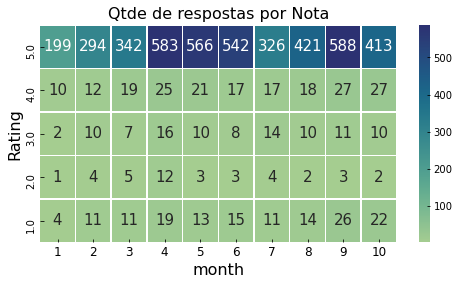

In [435]:
plt.figure(figsize=(8,4))
sns.heatmap(classificacao_por_mes_rating
            .sort_index(ascending=False), annot=True, fmt='d', linewidths=0.5, cmap="crest", annot_kws={"fontsize":15}
), plt.title('Qtde de respostas por Nota'), plt.savefig(IMAGES / 'res_por_nota.png');

Agora conseguimos olhar com mais clareza o que foi citado no case. Olhar apenas a média diária ou mensal pode "mascarar" o resultado inferior obtido no mês de julho. Acima, podemos notar uma queda de quase 40% no número de avaliações com nota 5. <p> 95% da queda total ocorrida entre o mês de junho e julho foi somente na avaliação 5 estrelas. <p>
**Contudo, não há aumento significativo nas avaliações 4, 3, 2 e 1. O que há é uma queda nas avaliações 5. Para termos mais segurança para dizer que os consumidores estão mais insatisfeitos, seria necessário haver um aumento das avaliações de faixas menores.**

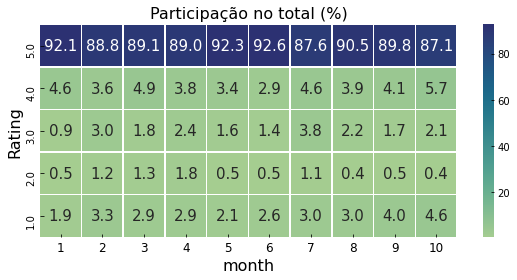

In [434]:
plt.figure(figsize=(8,4))
sns.heatmap(
    (classificacao.pivot_table(columns='Rating',
                          index='month',
                          values='OrderID',
                          aggfunc='count')
    .apply(lambda x: x/x.sum()*100, axis=1)
    .T)
    .sort_index(ascending=False), annot=True, fmt='.1f', linewidths=0.5, cmap="crest", annot_kws={"fontsize":15}
), plt.title('Participação no total (%)')
plt.tight_layout(), plt.savefig(IMAGES / 'par_por_nota.png');

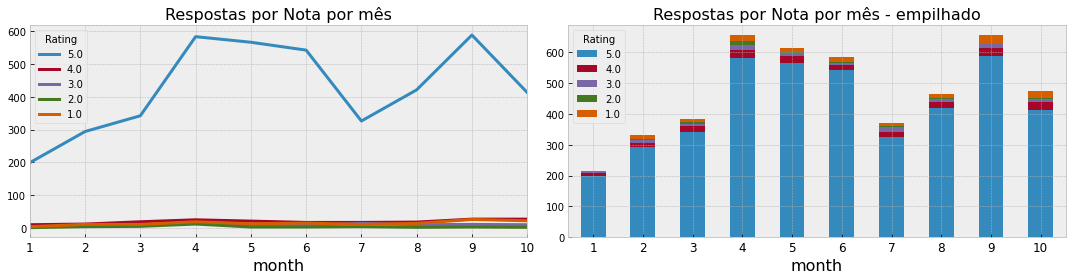

In [223]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4))

(classificacao_por_mes_rating
 .sort_index(ascending=False)
 .T
 .plot.line(ax=ax1, title='Respostas por Nota por mês', linewidth=3)
)
(classificacao_por_mes_rating
 .sort_index(ascending=False)
 .T
 .plot.bar(ax=ax2, title='Respostas por Nota por mês - empilhado', stacked=True), 
 plt.xticks(rotation=0)
), plt.tight_layout(), plt.savefig(IMAGES / 'av_por_nota.png');

Como pode ser observado, a quantidade de avaliações nota 5 caiu significativamente do mês de junho para o mês de julho. Os gráficos **parecem sugerir que não houve queda nas avaliações, houve queda nas avaliações de nota 5**, o que não necessariamente indica um aumento na insatisfação dos usuários/consumidores, já que não houve aumento no número das respostas 1, 2, 3 e 4. Vamos analisar mais um pouco.

Já que observamos um queda na quantidade de respostas em julho, sobretudo nas de nota 5, vamos olhar como foi a receita, número de pedidos e quantidade de clientes compradores, para veridicar se caem também.

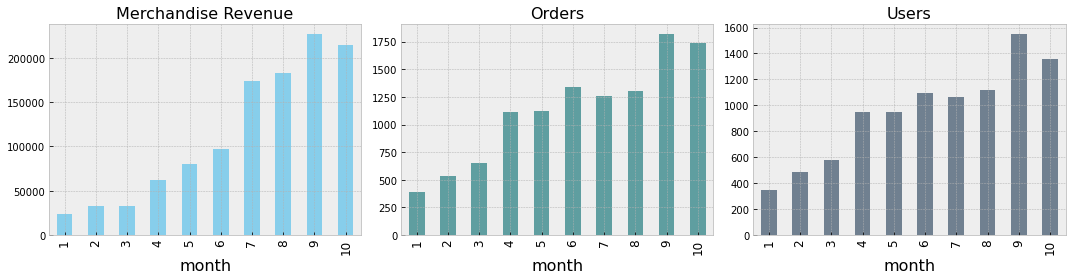

In [490]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

d = (Order_rating_DB
     .pivot_table(index='month',
                 values=['MerchandiseRevenue','OrderID','User'],
                 aggfunc={'MerchandiseRevenue': sum,
                          'OrderID': 'count', 
                          'User': pd.Series.nunique})
)
d['MerchandiseRevenue'].plot.bar(ax=ax1, color='skyblue', title='Merchandise Revenue')
d['OrderID'].plot.bar(ax=ax2, color='cadetblue', title='Orders')
d['User'].plot.bar(ax=ax3, color='slategray', title='Users')
plt.tight_layout(), plt.savefig(IMAGES / 'rev_ord_users.png' );

No mês de julho, a receita apresenta um aumento, mas o número de pedidos e usuários cai. A queda no número de pedidos ou clientes, se fosse mais expressiva, poderia ser uma das razões da queda das avaliações de nota 5. Contudo, não parece ser este o caso. Vamos olhar a quantidade de clientes distintos que avaliaram os pedidos ao longo dos meses.

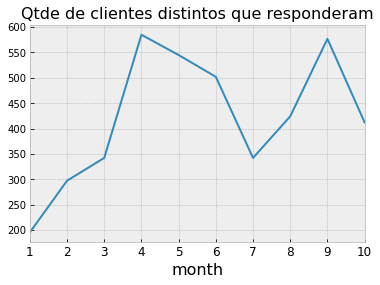

In [167]:
(classificacao
 .groupby('month')['User']
 .nunique()
 .plot(title="Qtde de clientes distintos que responderam")
);

Cai também! <p>
Vamos ver a métrica de receita por cliente.

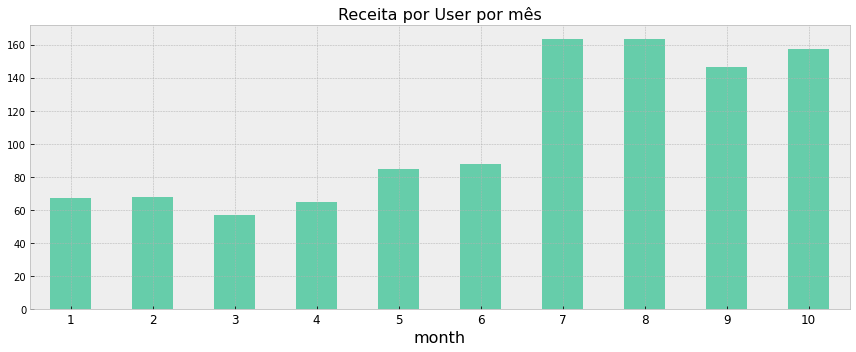

In [587]:
c_distintos = (Order_rating_DB
                 .groupby('month')['User']
                 .nunique()
)
q_orders = (Order_rating_DB
                 .groupby('month')['MerchandiseRevenue']
                 .sum()
)
(
 (q_orders / c_distintos)
 .plot.bar(title="Receita por User por mês", color='mediumaquamarine', figsize=(12,5))
), plt.xticks(rotation=0), plt.tight_layout(), plt.savefig(IMAGES / 'rec_por_user.png');

#### Cliente que concentra parte da receita

In [585]:
user12547 = Order_rating_DB.groupby(['month','User'])['MerchandiseRevenue'].sum()
user12547 = a.groupby(level=0).apply(lambda x: x/x.sum()*100)
b[user12547.index.isin(['user12547gmail.com'], level=1)].plot.bar()
plt.ylabel('Part (%) do total');

month  User              
5      user12547gmail.com     5.202803
6      user12547gmail.com     6.508483
7      user12547gmail.com    25.148917
8      user12547gmail.com    15.429135
9      user12547gmail.com    28.143933
10     user12547gmail.com    33.126565
Name: MerchandiseRevenue, dtype: float64

Vemos que há uma queda no número de pedidos por cliente do mês de junho para o mês de julho. Tanto número de pedido como número de user caiu, mas a queda de pedidos foi proporcionalmente maior que a queda de clientes. Será um fator sazonal?<p>
Vamos olhar a distribuição do pedidos entre os clientes nestes dois meses (junho e julho) 

In [169]:
# Quantidade de clientes por quantidade de pedidos
[Order_rating_DB.query("month == 6")['User'].value_counts().value_counts(sort=False, normalize=True).round(2),
Order_rating_DB.query("month == 7")['User'].value_counts().value_counts(sort=False, normalize=True).round(2)]

[1     0.90
 2     0.07
 3     0.02
 4     0.01
 6     0.00
 7     0.00
 12    0.00
 77    0.00
 Name: User, dtype: float64,
 1     0.91
 2     0.07
 3     0.01
 4     0.00
 5     0.00
 6     0.00
 8     0.00
 12    0.00
 59    0.00
 Name: User, dtype: float64]

As distribuições são parecidas.

Será que o período do dia em que o pedido é feito, influencia na quantidade de respostas ou na nota?

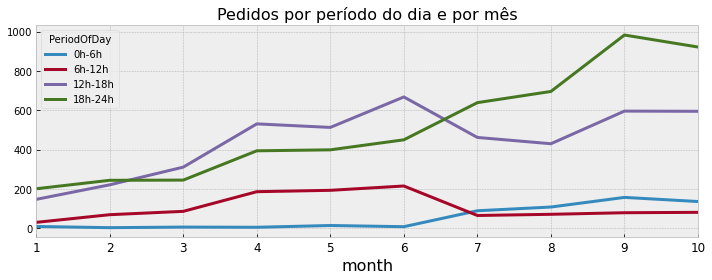

In [240]:
(Order_rating_DB
 .pivot_table(index='month',
              columns='PeriodOfDay',
              values='OrderID',
              aggfunc='count')
).plot(title='Pedidos por período do dia e por mês', linewidth=3, figsize=(10,4))
plt.tight_layout(), plt.savefig(IMAGES / 'ped_dia_mes.png');

Interessante notar uma queda número de pedidos do período "12-18" a partir do mês de julho. Os pedidos do período das "18-24" que vinha crescendo até junho, cresce ainda mais a patir de julho. <p> 
Vamos ver como é a avaliação média em cada período e em seguida abrir a quantidade de avaliações por nota e período.

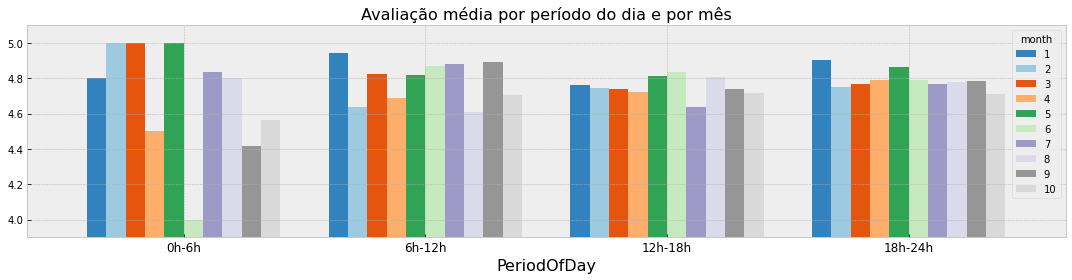

In [452]:
(classificacao
 .pivot_table(columns='month',
              index='PeriodOfDay',
              values='Rating',
              aggfunc='mean')
).plot.bar(title='Avaliação média por período do dia e por mês', linewidth=3, figsize=(15,4), ylim=(3.9, 5.1), width=0.8, colormap='tab20c')
plt.xticks(rotation=0), plt.tight_layout(), plt.savefig(IMAGES / 'av_por_periodo.png');

É possível observar que a queda na avaliação média ocorrida no mês de julho ocorre principalmente no período das 12h às 18hs. Vamos explorar isso mais um pouco.

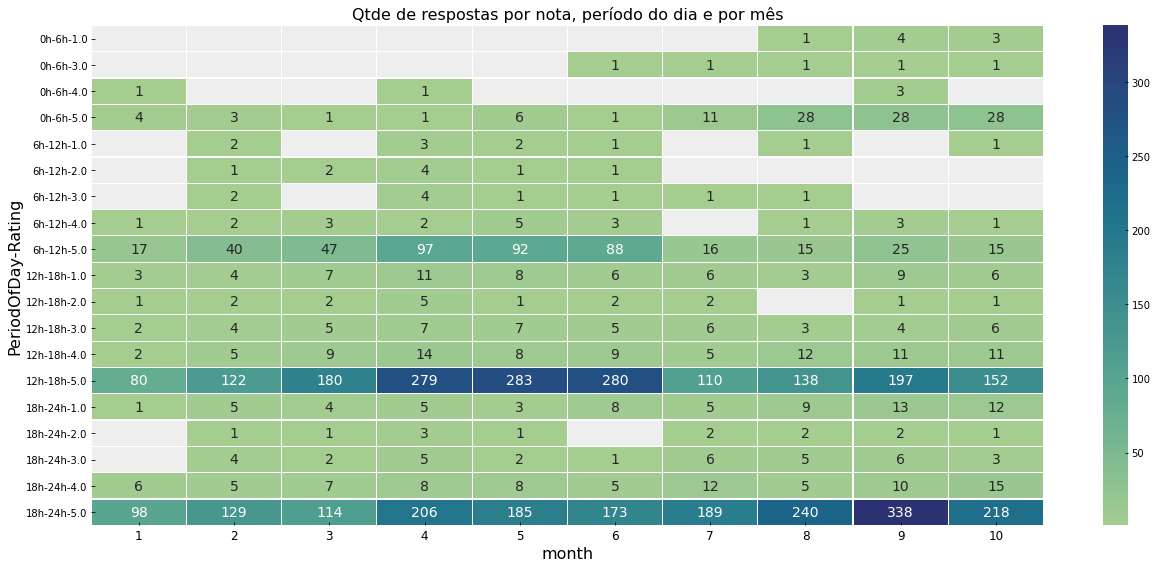

In [391]:
plt.figure(figsize=(18,8))
(sns.heatmap(
    (classificacao
     .pivot_table(columns='month',
                  index=['PeriodOfDay','Rating'],
                  values='OrderID',
                  aggfunc='count')
    ),  annot=True, fmt='.0f', linewidths=0.2, cmap="crest", annot_kws={"fontsize":14})
), plt.title("Qtde de respostas por nota, período do dia e por mês"), plt.tight_layout();

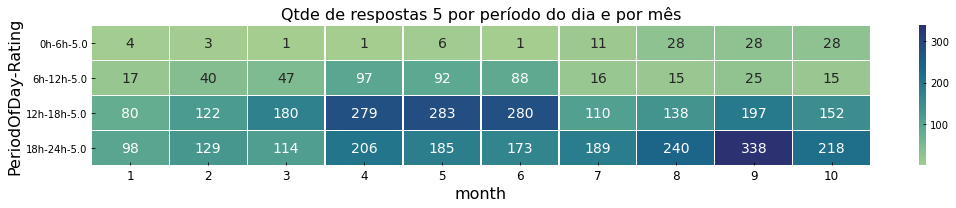

In [392]:
plt.figure(figsize=(15,3))
(sns.heatmap(
    (classificacao.query("Rating == 5")
     .pivot_table(columns='month',
                  index=['PeriodOfDay','Rating'],
                  values='OrderID',
                  aggfunc='count')
    ),  annot=True, fmt='.0f', linewidths=0.2, cmap="crest", annot_kws={"fontsize":14})
), plt.title("Qtde de respostas 5 por período do dia e por mês"), plt.tight_layout(), plt.savefig(IMAGES / 'resp_nota_5_period.png');

Vê-se que a maior queda no número de avaliações 5 estrelas ocorre no período "12-18". Esta queda de cerca de 170 avaliações (280-110) representa quase 80% da queda total de avaliações 5 estrelas.  Em seguida, o período 6h-12h também apresenta queda <p>
O que está acontecendo com este período? Estamos perdendo vendas? Pedidos? Clientes? Havíamos observado que este período do dia teve redução de pedidos nos meses julho e agosto, vamos aprofunda mais um pouco.

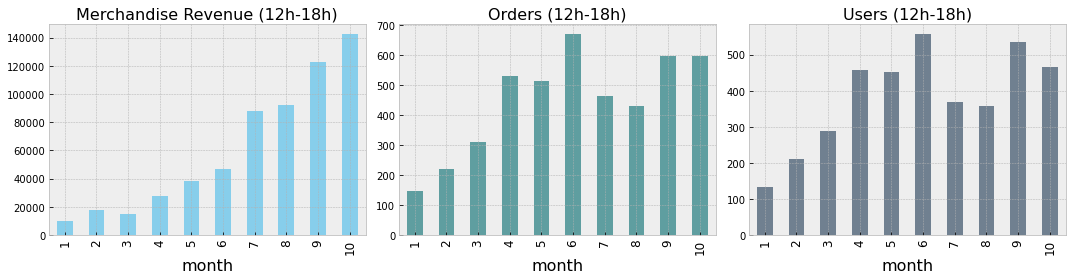

In [393]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

d2 = (Order_rating_DB.query("PeriodOfDay == '12h-18h'")
     .pivot_table(index='month',
                 values=['MerchandiseRevenue','OrderID','User'],
                 aggfunc={'MerchandiseRevenue': sum,
                          'OrderID': 'count', 
                          'User': pd.Series.nunique})
)
d2['MerchandiseRevenue'].plot.bar(ax=ax1, color='skyblue', title='Merchandise Revenue (12h-18h)')
d2['OrderID'].plot.bar(ax=ax2, color='cadetblue', title='Orders (12h-18h)')
d2['User'].plot.bar(ax=ax3, color='slategray', title='Users (12h-18h)')
plt.tight_layout(), plt.savefig(IMAGES / 'rev_ord_users_12_18.png' );

Vemos que neste período do dia (12h-18h), temos uma redução de clientes e de pedidos, apesar da receita não estar caindo. Isso nos leva a verificar como está a receita por pedido e a receita por cliente.

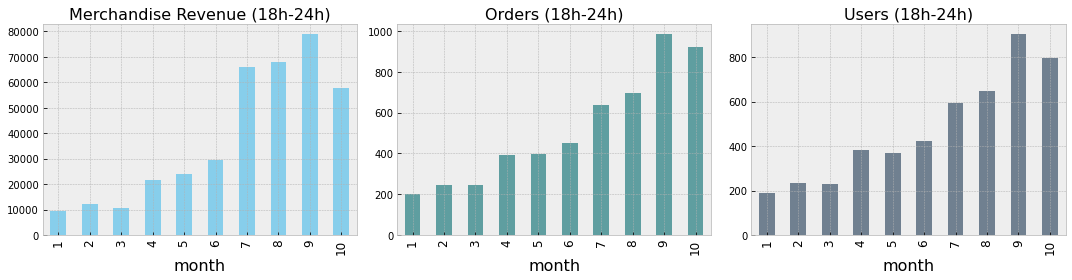

In [204]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

d3 = (Order_rating_DB.query("PeriodOfDay == '18h-24h'")
     .pivot_table(index='month',
                 values=['MerchandiseRevenue','OrderID','User'],
                 aggfunc={'MerchandiseRevenue': sum,
                          'OrderID': 'count', 
                          'User': pd.Series.nunique})
)
d3['MerchandiseRevenue'].plot.bar(ax=ax1, color='skyblue', title='Merchandise Revenue (18h-24h)')
d3['OrderID'].plot.bar(ax=ax2, color='cadetblue', title='Orders (18h-24h)')
d3['User'].plot.bar(ax=ax3, color='slategray', title='Users (18h-24h)')
plt.tight_layout();

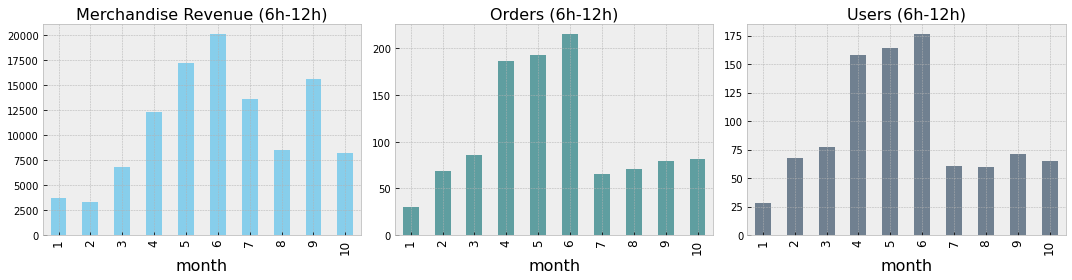

In [398]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

d2 = (Order_rating_DB.query("PeriodOfDay == '6h-12h'")
     .pivot_table(index='month',
                 values=['MerchandiseRevenue','OrderID','User'],
                 aggfunc={'MerchandiseRevenue': sum,
                          'OrderID': 'count', 
                          'User': pd.Series.nunique})
)
d2['MerchandiseRevenue'].plot.bar(ax=ax1, color='skyblue', title='Merchandise Revenue (6h-12h)')
d2['OrderID'].plot.bar(ax=ax2, color='cadetblue', title='Orders (6h-12h)')
d2['User'].plot.bar(ax=ax3, color='slategray', title='Users (6h-12h)')
plt.tight_layout(),  plt.savefig(IMAGES / 'rev_ord_users_6_12.png');

Neste período, a queda parece ser ainda mais severa e persistente. Tanto receita como pedidos e users caem após o mês de junho.

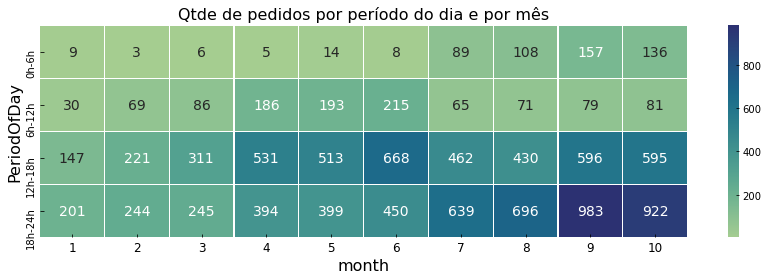

In [203]:
plt.figure(figsize=(12,4))
(sns.heatmap(
    (Order_rating_DB
     .pivot_table(columns='month',
                  index=['PeriodOfDay'],
                  values='OrderID',
                  aggfunc='count')
    ),  annot=True, fmt='.0f', linewidths=0.2, cmap="crest", annot_kws={"fontsize":14})
), plt.title("Qtde de pedidos por período do dia e por mês"), plt.tight_layout();

Aparentemente, o investimento na campanha está surtindo efeito mais no período "18-24", onde a avaliação permanece estável. Esse período vem apresentando aumento de pedidos e clientes.

### O que acontece com a avaliação se removermos o período diurno (6h-18h) dos dados?

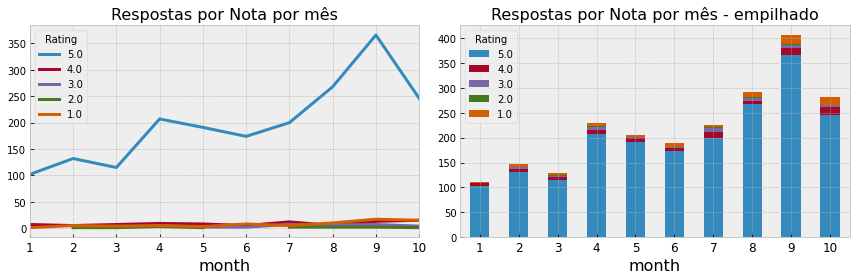

In [399]:
classificacao_por_mes_rating_sem_12_18 = classificacao.query("PeriodOfDay != '6h-12h' and PeriodOfDay != '12h-18h'").pivot_table(index='Rating',
                                                                                                          columns='month',
                                                                                                          values='OrderID',
                                                                                                          aggfunc='count')
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))

(classificacao_por_mes_rating_sem_12_18
 .sort_index(ascending=False)
 .T
 .plot.line(ax=ax1, title='Respostas por Nota por mês', linewidth=3)
)
(classificacao_por_mes_rating_sem_12_18
 .sort_index(ascending=False)
 .T
 .plot.bar(ax=ax2, title='Respostas por Nota por mês - empilhado', stacked=True), 
 plt.xticks(rotation=0)
), plt.tight_layout(), plt.savefig(IMAGES / 'av_por_nota_noturno.png');

Os dados passam a mostrar um cenário totalmente diferente.

<AxesSubplot:xlabel='month'>

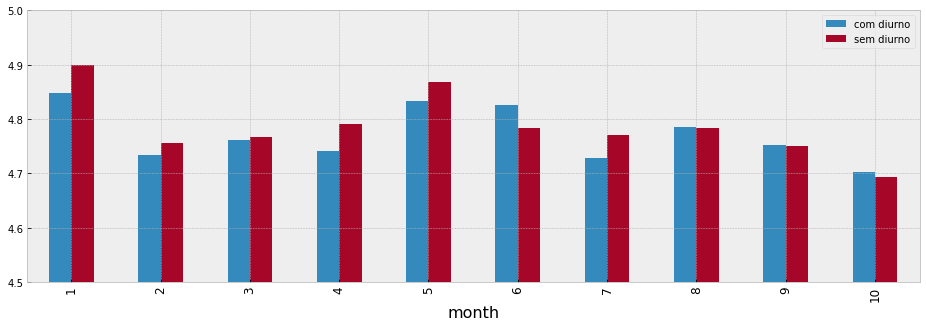

In [588]:
pd.DataFrame({'com diurno': classificacao.groupby('month')['Rating'].mean(),
             'sem diurno': (classificacao.query("PeriodOfDay != '6h-12h' and PeriodOfDay != '12h-18h'").groupby('month')['Rating'].mean())}
            ).plot.bar(ylim=(4.5,5), figsize=(16,5));

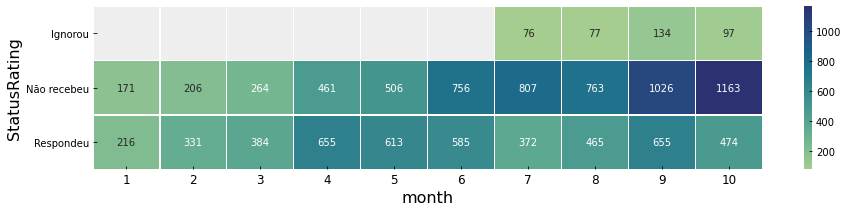

In [215]:
# Vamos  observar a quantidade de registros com alguma avaliação x a quantidade total de registros ao longo do ano
Order_rating_DB['StatusRating'] = (
    Order_rating_DB['Rating'].apply(lambda x: 'Ignorou' if x==-1.0 else 'Não recebeu' if pd.isna(x)==True or x==0 else "Respondeu")
)
plt.figure(figsize=(15,3))
registros_por_status_rating = Order_rating_DB.pivot_table(
                                index='StatusRating',
                                columns='month',
                                values='OrderID',
                                aggfunc='count'
                               )
(sns.heatmap(
        registros_por_status_rating,
        annot=True, fmt='.0f', linewidths=0.5, cmap="crest")
);

Porque antes do mes de julho não há casos "ignorou"?

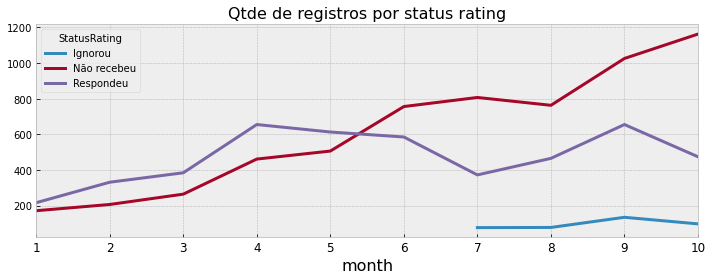

In [389]:
(registros_por_status_rating
 .T
 .plot(title='Qtde de registros por status rating', linewidth=3, figsize=(10,4))
), plt.tight_layout(), plt.savefig(IMAGES / 'reg_por_nota.png');

O número de clientes sem receber a avaliação cresceu muito ao longo do ano, ao passo que o número de clientes que recebeu o e-mail para avaliação cai bastante em Julho. Isso sugere que precisamos enviar os e-mails solicitando a avaliação. A ausencia das avaliações tende a penalizar mais a nota 5, já que ele representa cerca de 90% do total das avaliações. <p> 
**Hipótese:** Será que os clientes que não receberam são, em sua maioria, os clientes que antes davam nota 5?

In [217]:
# Vamos pegar os clientes que responderam com nota 5 nos meses abril, maio e junho
clientes_nota_5 = set(Order_rating_DB.query("month >=4 and month <=6 and Rating == 5")['User'])

# Agora, os clientes que compraram no mês de julho e não receberam o e-mail
cliente_mes_julho = set(Order_rating_DB.query("month == 7 and MerchandiseRevenue > 0 and StatusRating == 'Não recebeu'")['User'])

# A intersecção entre os dois
c = clientes_nota_5.intersection(cliente_mes_julho)

# Enfim, vamos olhar estes casos
(
    Order_rating_DB[Order_rating_DB['User'].isin(c)]
     .query("month >=4 and month <=7")
     .pivot_table(
        index=['User','OrderNumber'],
        columns='month',
        values=['Rating','MerchandiseRevenue'],
        aggfunc={'Rating':'mean', 'MerchandiseRevenue':'sum'}
 )
)

MerchandiseRevenue                            \
month                                           4       5        6        7   
User               OrderNumber                                                
user10264gmail.com 37068                      NaN  34.368      NaN      NaN   
                   40800                      NaN  34.368      NaN      NaN   
                   41395                      NaN  34.368      NaN      NaN   
                   47883                      NaN     NaN   41.536      NaN   
                   49162                      NaN     NaN  210.816      NaN   
                   79133153                   NaN     NaN      NaN  389.088   
                   94654591                   NaN     NaN      NaN  355.488   
user10279gmail.com 39515                      NaN  32.448      NaN      NaN   
                   41442                      NaN  32.448      NaN      NaN   
                   72626063                   NaN     NaN      NaN   18.192   
user10470gmail.com 37568                      NaN  38.512      NaN      NaN   
                   40173                      NaN  30.528      NaN      NaN   
                   43743                      NaN  44.424      NaN      NaN   
                   97359834                   NaN     NaN      NaN   30.528   
user10647gmail.com 53477                      NaN     NaN   28.672      NaN   
                   56872                      NaN     NaN      NaN   29.544   
user10927gmail.com 38657                      NaN  35.424      NaN      NaN   
                   25649501                   NaN     NaN      NaN   62.304   
user10945gmail.com 41155                      NaN  32.424      NaN      NaN   
                   43459                      NaN  30.744      NaN      NaN   
                   34549405                   NaN     NaN      NaN   43.920   
user1107gmail.com  31987                   61.296     NaN      NaN      NaN   
                   39256                      NaN  51.696      NaN      NaN   
                   55813                      NaN     NaN  271.872      NaN   
                   81000240                   NaN     NaN      NaN  103.392   
user1124gmail.com  39068                      NaN  28.752      NaN      NaN   
                   45489                      NaN  38.336      NaN      NaN   
                   47003                      NaN     NaN   29.736      NaN   
                   56536                      NaN     NaN      NaN   39.456   
                   70552141                   NaN     NaN      NaN   83.856   
...                                           ...     ...      ...      ...   
user9308gmail.com  34810                   28.752     NaN      NaN      NaN   
                   36792                      NaN  32.448      NaN      NaN   
                   36800                      NaN  28.752      NaN      NaN   
                   36961                      NaN  32.448      NaN      NaN   
                   36962                      NaN  32.448      NaN      NaN   
                   36963                      NaN  32.448      NaN      NaN   
                   39181                      NaN  32.448      NaN      NaN   
                   40870                      NaN  32.448      NaN      NaN   
                   40871                      NaN  32.448      NaN      NaN   
                   40872                      NaN  32.448      NaN      NaN   
                   43503                      NaN  32.448      NaN      NaN   
                   50786                      NaN     NaN   32.448      NaN   
                   15781043                   NaN     NaN      NaN   40.896   
                   30428952                   NaN     NaN      NaN   40.896   
                   42391552                   NaN     NaN      NaN   40.896   
                   83260620                   NaN     NaN      NaN   20.448   
user9322gmail.com  47721                      NaN     NaN   47.920      NaN   
  

Encontramos 141 clientes que compraram pelo menos uma vez entre os meses abril e junho - e deram nota 5 - e no mês de julho compraram novamente, mas não recebeam o e-mail para avaliação. Não sabemos, claro, se estes clientes avaliariam novamente com nota 5. Poderíamos analisar qual a % de clientes que, após dar uma nota 5 na primeira compra, avaliam novamente com nota 5 na terceira compra, e na quarta... etc. Contudo, como houve mudança da plataforma a partir do mês de julho, o padrão observado anteriormente pode ser alterado.

Vamos verficar com é o comportamento das avaliações entre os estados.

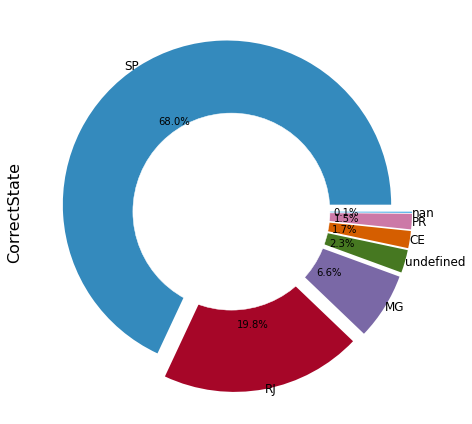

In [218]:
graf_rosca = plt.Circle((0, 0), 0.6, color='white')

(classificacao['CorrectState']
 .value_counts(normalize=True, dropna=False)
 .plot
 .pie(figsize=(8,6), 
      autopct='%1.1f%%', 
      explode=(0.05,0.1,0.1,0.1,0.1,0.1,0.1),
      labeldistance=1
      )
);
plt.gca().add_artist(graf_rosca)
plt.tight_layout()

Quase 70% das avaliações vieram de SP. Vamos olhar o comportamento das avaliações ao longo do ano por estado para ver se a queda no mês sete ficou concentrada. 

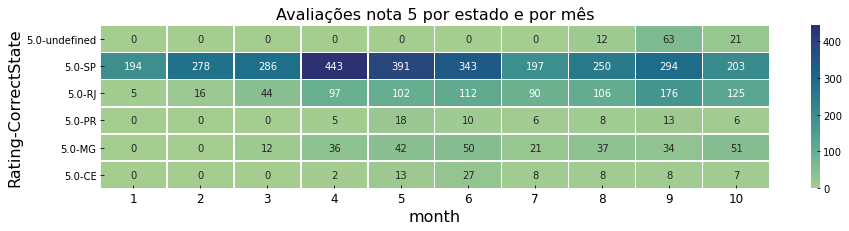

In [219]:
plt.figure(figsize=(15,3))
(sns.heatmap(
    (classificacao
     .query("Rating == 5")
     .pivot_table(index=['Rating','CorrectState'],
                  columns='month',
                  values='OrderID',
                  aggfunc='count',
                 dropna=False)
     .sort_index(ascending=False)
     .fillna(0)
     .astype(int)
    ),
        annot=True, fmt='.0f', linewidths=0.5, cmap="crest")
),plt.title('Avaliações nota 5 por estado e por mês');

A queda no número de avaliações com nota 5 não cai apenas em SP, mas nos demais estados também. <p>
Já vimos anteriormente que a queda no número de envios do e-mail para avaliação cai no mês de julho. Isso posso indicar que a queda nas avaliações de nota 5 pode estar relacionada a queda nos envios destes e-mails. Os clientes não estão recebendo o e-mail para então poder avaliar com nota 5.

A avalição média é igual para quem compra uma vez em relação a quem compra mais de uma vez? Avaliação por pedido, não por mes.

In [326]:
Order_rating_DB.groupby('User')['OrderID'].count().sort_values()

User
user10001gmail.com      1
user28724gmail.com      1
user28720gmail.com      1
user28708gmail.com      1
user286gmail.com        1
user28699gmail.com      1
user28686gmail.com      1
user28662gmail.com      1
user28656gmail.com      1
user28655gmail.com      1
user28654gmail.com      1
user28727gmail.com      1
user28646gmail.com      1
user28631gmail.com      1
user28623gmail.com      1
user28617gmail.com      1
user28612gmail.com      1
user28611gmail.com      1
user28599gmail.com      1
user28592gmail.com      1
user28584gmail.com      1
user28583gmail.com      1
user28579gmail.com      1
user28644gmail.com      1
user28576gmail.com      1
user28734gmail.com      1
user2873gmail.com       1
user28838gmail.com      1
user28837gmail.com      1
user28831gmail.com      1
                     ... 
user5621gmail.com      10
user7668gmail.com      11
user22837gmail.com     11
user7500gmail.com      11
user26081gmail.com     11
user4764gmail.com      11
user91gmail.com        11
user375

In [360]:
users_ = (Order_rating_DB[['User','Date&Time']]
          .sort_values(['User','Date&Time'])
          .reset_index(drop=True)
         )
users_ = users_['User']

In [371]:
row = 0
count = 1
QtdeCompras = []
while row < len(users_):
    
    if users_.iloc[row] == users_.iloc[row-1]:
         count = count + 1
    else:
        count = 1
    
    QtdeCompras.append(count)
    row=row+1

Order_rating_DB.sort_values(['User','Date&Time'], inplace=True)
Order_rating_DB['QtdeCompras'] = QtdeCompras

In [386]:
# Adicionar colunas
bins = [0,1,2,100]
labels = ['1x', '2x', '3x ou mais']
Order_rating_DB['QtdeComprasLabel'] = pd.cut(Order_rating_DB['QtdeCompras'], bins=bins, labels=labels)

filtro = [-1,0,np.nan]
classificacao2 = Order_rating_DB[~Order_rating_DB['Rating'].isin(filtro)]

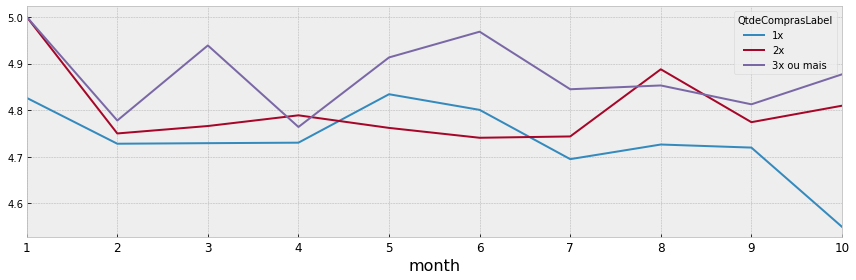

In [387]:
(classificacao2.pivot_table(
    index='month',
    columns='QtdeComprasLabel',
    values='Rating',
    aggfunc='mean'
    )
).plot(figsize=(12,4))
plt.tight_layout();

In [589]:
atraso = ['user26821gmail.com','user15751gmail.com','user18204gmail.com','user28903gmail.com',
'user3082gmail.com','user22641gmail.com','user27414gmail.com','user27405gmail.com',
'user27182gmail.com','user9805gmail.com','user8296gmail.com','user26932gmail.com',
'user4882gmail.com','user20984gmail.com','user9489gmail.com','user26040gmail.com',
'user25633gmail.com','user16919gmail.com']


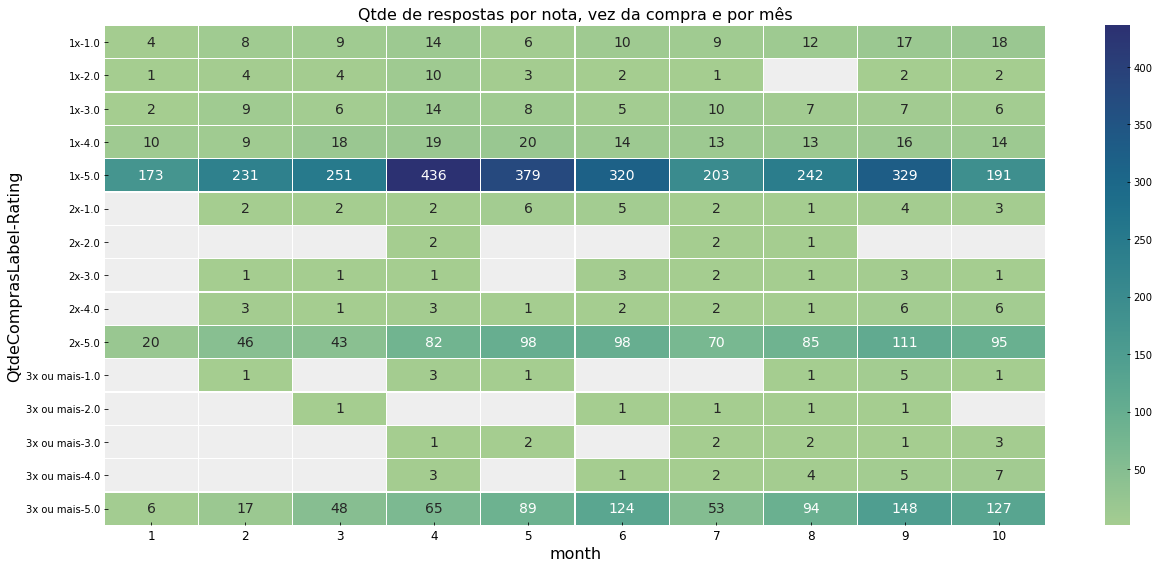

In [592]:
plt.figure(figsize=(18,8))
(sns.heatmap(
    (classificacao2
     .pivot_table(columns='month',
                  index=['QtdeComprasLabel','Rating'],
                  values='OrderID',
                  aggfunc='count')
    ),  annot=True, fmt='.0f', linewidths=0.2, cmap="crest", annot_kws={"fontsize":14})
), plt.title("Qtde de respostas por nota, vez da compra e por mês"), plt.tight_layout();

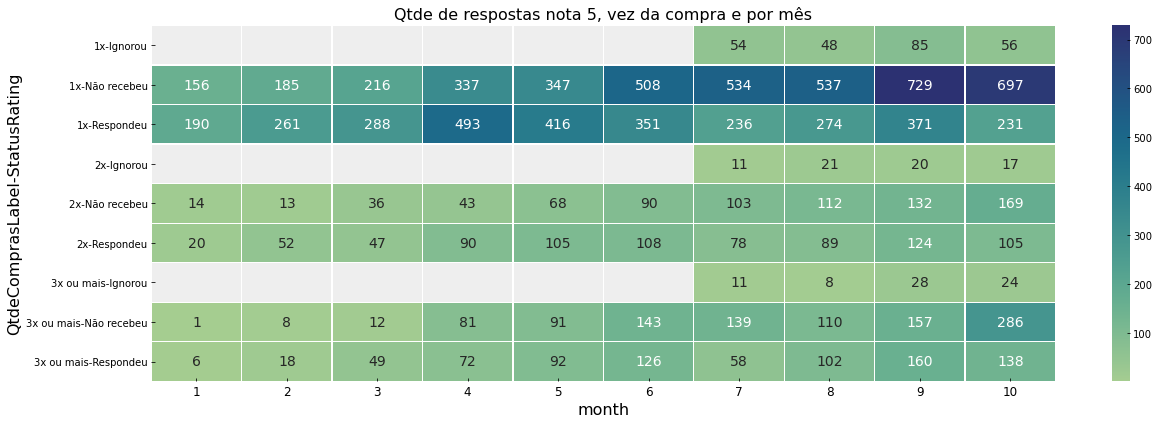

In [420]:
plt.figure(figsize=(18,6))
(sns.heatmap(
    (Order_rating_DB
     .pivot_table(columns='month',
                  index=['QtdeComprasLabel','StatusRating'],
                  values='OrderID',
                  aggfunc='count')
    ),  annot=True, fmt='.0f', linewidths=0.2, cmap="crest", annot_kws={"fontsize":14})
), plt.title("Qtde de respostas nota 5, vez da compra e por mês"), plt.tight_layout();

A taxa de resposta ( ignorou / (ignorou + respondeu) ) melhora, a medida que o número de compras aumenta.